In [1]:
import os
import numpy as np
import cv2
import math
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, BatchNormalization, Dropout
from keras.layers import Dense, Flatten
from tensorflow.keras.utils import to_categorical
from keras.models import Model

######train
X=[]
def ReFileName(dirPath):

    for file in os.listdir(dirPath):
        if os.path.isfile(os.path.join(dirPath, file)) == True:
            c= os.path.basename(file)
            name = dirPath + '\\' + c
            img = cv2.imread(name)
            img = cv2.resize(img,(100,100))
            X.append(img)

dirPath = r"D:\Academic\PhD\Research\data\FOOTBALLTRAIN"
ReFileName(dirPath)
X=np.array(X)
print('x.shape',X.shape)
#y=[1 for i in range(len(cat))]
#y=np.array(y)
#print('y.shape',y.shape)
X = X.astype('float32')
X /= 255
X



X_valid=[]
def ReFileName(dirPath):

    for file in os.listdir(dirPath):
        if os.path.isfile(os.path.join(dirPath, file)) == True:
            c= os.path.basename(file)
            name = dirPath + '\\' + c
            img = cv2.imread(name)
            img = cv2.resize(img,(100,100))
            X_valid.append(img)

dirPath = r"D:\Academic\PhD\Research\data\FOOTBALLVAL"
ReFileName(dirPath)
X_valid=np.array(X_valid)
print('X_valid.shape',X_valid.shape)

X_valid = X_valid.astype('float32')
X_valid /= 255
X_valid


####test
X_test=[]
def ReFileName(dirPath):

    for file in os.listdir(dirPath):
        if os.path.isfile(os.path.join(dirPath, file)) == True:
            c= os.path.basename(file)
            name = dirPath + '\\' + c
            img = cv2.imread(name)
            img = cv2.resize(img,(100,100))
            X_test.append(img)

dirPath = r"D:\Academic\PhD\Research\data\FOOTBALLTEST"
ReFileName(dirPath)
X_test=np.array(X_test)
print('X_test.shape',X_test.shape)

X_test = X_test.astype('float32')
X_test /= 255
X_test

np.save('X',X)
np.save('X_valid',X_valid)
np.save('X_test',X_test)

x.shape (300, 100, 100, 3)
X_valid.shape (300, 100, 100, 3)
X_test.shape (300, 100, 100, 3)


In [2]:
joint = pd.read_table('D:\\Academic\\PhD\\Research\\data\\annotation.txt',sep='\t',header=None) 
print('joint:',joint)###28
joint.shape
y = joint[0:8400]
y_valid = joint[28000:36400]
y_test = joint[42000:50400]
y = np.array(y).reshape(300,28)
y_valid = np.array(y_valid).reshape(300,28)
y_test = np.array(y_test).reshape(300,28)
np.save('y',y)
np.save('y_test',y_test)
#print('y:',y,y.shape)
#print('y_test:',y_test,y_test.shape)

joint:                  0
0       113.179460
1       190.348840
2       149.765850
3       174.206010
4       117.253180
...            ...
165391   91.708069
165392  122.023640
165393   55.353383
165394  123.006200
165395   26.367890

[165396 rows x 1 columns]


In [9]:
# model = Sequential()
# model.add(Conv2D(128, kernel_size=(5,5), activation='gelu', input_shape=(100, 100, 3)))
# model.add(MaxPool2D(pool_size=(2,2), padding='same'))
# model.add(Conv2D(128, kernel_size=(3,3), activation='gelu'))
# model.add(MaxPool2D(pool_size=(2,2), padding='same'))
# model.add(Flatten())
# model.add(Dense(64, activation='gelu'))
# model.add(Dense(28, activation='gelu'))


In [10]:
y_prediction = []
euclidean_dis = []
for i in range(10):
    
    model = Sequential()
    model.add(Conv2D(filters=96,kernel_size=11,strides=4,activation='gelu',input_shape=(100, 100, 3)))
    model.add(MaxPool2D(pool_size=3, strides=2))
    model.add(Conv2D(filters=256,kernel_size=5,padding='same',activation='gelu'))
    model.add(MaxPool2D(pool_size=3, strides=2))
    model.add(Conv2D(filters=384,kernel_size=3,padding='same',activation='gelu'))
    model.add(Conv2D(filters=384,kernel_size=3,padding='same',activation='gelu'))
    model.add(Conv2D(filters=256,kernel_size=3,padding='same',activation='gelu'))
    model.add(MaxPool2D(pool_size=3, strides=2))
    model.add(Flatten())
    model.add(Dense(4096,activation='gelu'))
    model.add(Dropout(0.5))
    model.add(Dense(4096,activation='gelu'))
    model.add(Dropout(0.5))
    model.add(Dense(28))
    
    model.compile(
              'Adam',
              loss='mse',
              metrics=['MeanAbsoluteError'])
    print("========start",i,"============")
    y_a = y/2.5
    y_valid_a = y_valid/2.5
    y_test_a = y_test/2.5
    history = model.fit(X,y_a,
           batch_size=50,
           epochs=30,
           verbose=2,
           validation_data=(X_valid[0:50],y_valid_a[0:50]))
    print("========end============")
    
    layer_model_train = Model(inputs = model.input,outputs = model.layers[-1].output)
    feature_test = layer_model_train.predict(X_test)
    y_pred = model.predict(X_test)
    y_prediction.append(y_pred)
    
    diff = (y_test_a-y_pred)**2
    diff = diff.reshape((300,14,2))
    eu_dis = np.empty((300,14))
    for i in range(300):
        for j in range(14):
            eu_dis[i][j] = np.sqrt(sum(diff[i][j]))
    #eu_dis
    avg_eu_dis = []#each picture
    for i in range(eu_dis.shape[0]):
        avg_eu_dis.append(np.mean(eu_dis[i,:]))
    #print('avg eu dis in each picture:',avg_eu_dis,'\n','#test picture:',len(avg_eu_dis),'\n','overall_avg:',np.mean(avg_eu_dis))
    euclidean_dis.append(np.mean(avg_eu_dis))
print(np.mean(euclidean_dis))

========start 0 ============
Epoch 1/30
6/6 - 3s - loss: 18378.8379 - mean_absolute_error: 82.2665 - val_loss: 2161.0881 - val_mean_absolute_error: 43.8678 - 3s/epoch - 533ms/step
Epoch 2/30
6/6 - 3s - loss: 1959.6477 - mean_absolute_error: 41.6894 - val_loss: 1503.8107 - val_mean_absolute_error: 36.6006 - 3s/epoch - 543ms/step
Epoch 3/30
6/6 - 5s - loss: 1453.0754 - mean_absolute_error: 35.9504 - val_loss: 745.0154 - val_mean_absolute_error: 25.8566 - 5s/epoch - 786ms/step
Epoch 4/30
6/6 - 5s - loss: 522.1945 - mean_absolute_error: 19.2113 - val_loss: 207.9865 - val_mean_absolute_error: 12.3585 - 5s/epoch - 767ms/step
Epoch 5/30
6/6 - 5s - loss: 320.7584 - mean_absolute_error: 14.5253 - val_loss: 118.9677 - val_mean_absolute_error: 8.6110 - 5s/epoch - 781ms/step
Epoch 6/30
6/6 - 8s - loss: 221.7284 - mean_absolute_error: 11.8171 - val_loss: 116.2594 - val_mean_absolute_error: 8.6121 - 8s/epoch - 1s/step
Epoch 7/30
6/6 - 9s - loss: 192.6041 - mean_absolute_error: 11.0311 - val_loss: 11

Epoch 27/30
6/6 - 15s - loss: 65.9654 - mean_absolute_error: 6.0982 - val_loss: 85.9882 - val_mean_absolute_error: 6.3866 - 15s/epoch - 3s/step
Epoch 28/30
6/6 - 15s - loss: 66.2166 - mean_absolute_error: 6.1170 - val_loss: 82.6821 - val_mean_absolute_error: 6.3211 - 15s/epoch - 2s/step
Epoch 29/30
6/6 - 14s - loss: 65.6842 - mean_absolute_error: 6.1192 - val_loss: 86.6623 - val_mean_absolute_error: 6.3910 - 14s/epoch - 2s/step
Epoch 30/30
6/6 - 14s - loss: 67.4016 - mean_absolute_error: 6.1766 - val_loss: 91.5219 - val_mean_absolute_error: 6.5722 - 14s/epoch - 2s/step
========end============
========start 2 ============
Epoch 1/30
6/6 - 33s - loss: 50267.6016 - mean_absolute_error: 107.7771 - val_loss: 1839.3203 - val_mean_absolute_error: 40.5210 - 33s/epoch - 6s/step
Epoch 2/30
6/6 - 14s - loss: 1714.2850 - mean_absolute_error: 39.2890 - val_loss: 1492.4709 - val_mean_absolute_error: 36.6309 - 14s/epoch - 2s/step
Epoch 3/30
6/6 - 14s - loss: 2484.6162 - mean_absolute_error: 45.4519 -

Epoch 23/30
6/6 - 14s - loss: 141.0854 - mean_absolute_error: 9.3526 - val_loss: 83.6471 - val_mean_absolute_error: 6.3704 - 14s/epoch - 2s/step
Epoch 24/30
6/6 - 14s - loss: 129.2702 - mean_absolute_error: 8.8949 - val_loss: 83.7848 - val_mean_absolute_error: 6.5011 - 14s/epoch - 2s/step
Epoch 25/30
6/6 - 14s - loss: 133.8927 - mean_absolute_error: 9.1097 - val_loss: 86.3278 - val_mean_absolute_error: 6.3749 - 14s/epoch - 2s/step
Epoch 26/30
6/6 - 14s - loss: 124.7906 - mean_absolute_error: 8.7854 - val_loss: 82.7864 - val_mean_absolute_error: 6.2900 - 14s/epoch - 2s/step
Epoch 27/30
6/6 - 14s - loss: 124.3065 - mean_absolute_error: 8.7338 - val_loss: 84.6610 - val_mean_absolute_error: 6.2314 - 14s/epoch - 2s/step
Epoch 28/30
6/6 - 14s - loss: 119.9387 - mean_absolute_error: 8.5848 - val_loss: 89.3592 - val_mean_absolute_error: 6.4567 - 14s/epoch - 2s/step
Epoch 29/30
6/6 - 13s - loss: 120.7947 - mean_absolute_error: 8.5910 - val_loss: 84.4483 - val_mean_absolute_error: 6.4093 - 13s/e

Epoch 19/30
6/6 - 15s - loss: 253.8793 - mean_absolute_error: 12.5360 - val_loss: 89.9581 - val_mean_absolute_error: 7.0094 - 15s/epoch - 2s/step
Epoch 20/30
6/6 - 13s - loss: 210.1790 - mean_absolute_error: 11.3909 - val_loss: 89.5403 - val_mean_absolute_error: 6.9934 - 13s/epoch - 2s/step
Epoch 21/30
6/6 - 13s - loss: 228.9094 - mean_absolute_error: 11.9651 - val_loss: 83.6436 - val_mean_absolute_error: 6.4591 - 13s/epoch - 2s/step
Epoch 22/30
6/6 - 13s - loss: 191.7378 - mean_absolute_error: 10.9225 - val_loss: 91.3273 - val_mean_absolute_error: 6.6555 - 13s/epoch - 2s/step
Epoch 23/30
6/6 - 14s - loss: 199.7533 - mean_absolute_error: 11.1181 - val_loss: 86.4158 - val_mean_absolute_error: 6.8486 - 14s/epoch - 2s/step
Epoch 24/30
6/6 - 13s - loss: 180.1707 - mean_absolute_error: 10.6213 - val_loss: 90.4437 - val_mean_absolute_error: 6.6647 - 13s/epoch - 2s/step
Epoch 25/30
6/6 - 15s - loss: 176.7972 - mean_absolute_error: 10.4475 - val_loss: 85.9042 - val_mean_absolute_error: 6.4617 

Epoch 15/30
6/6 - 12s - loss: 133.3027 - mean_absolute_error: 9.1279 - val_loss: 84.3916 - val_mean_absolute_error: 6.3166 - 12s/epoch - 2s/step
Epoch 16/30
6/6 - 13s - loss: 130.9443 - mean_absolute_error: 8.9433 - val_loss: 84.5323 - val_mean_absolute_error: 6.3816 - 13s/epoch - 2s/step
Epoch 17/30
6/6 - 13s - loss: 128.9971 - mean_absolute_error: 8.9152 - val_loss: 85.4739 - val_mean_absolute_error: 6.3934 - 13s/epoch - 2s/step
Epoch 18/30
6/6 - 15s - loss: 126.7664 - mean_absolute_error: 8.8372 - val_loss: 86.0995 - val_mean_absolute_error: 6.4856 - 15s/epoch - 2s/step
Epoch 19/30
6/6 - 15s - loss: 123.9156 - mean_absolute_error: 8.6963 - val_loss: 90.3725 - val_mean_absolute_error: 6.5579 - 15s/epoch - 2s/step
Epoch 20/30
6/6 - 13s - loss: 117.9626 - mean_absolute_error: 8.5246 - val_loss: 83.9122 - val_mean_absolute_error: 6.3516 - 13s/epoch - 2s/step
Epoch 21/30
6/6 - 14s - loss: 120.3198 - mean_absolute_error: 8.5885 - val_loss: 87.1400 - val_mean_absolute_error: 6.4276 - 14s/e

6/6 - 13s - loss: 157.6010 - mean_absolute_error: 9.9194 - val_loss: 89.9997 - val_mean_absolute_error: 6.6298 - 13s/epoch - 2s/step
Epoch 11/30
6/6 - 14s - loss: 157.3055 - mean_absolute_error: 9.9476 - val_loss: 86.0918 - val_mean_absolute_error: 6.3536 - 14s/epoch - 2s/step
Epoch 12/30
6/6 - 14s - loss: 146.5193 - mean_absolute_error: 9.5416 - val_loss: 87.3701 - val_mean_absolute_error: 6.4288 - 14s/epoch - 2s/step
Epoch 13/30
6/6 - 13s - loss: 138.5213 - mean_absolute_error: 9.3301 - val_loss: 86.8544 - val_mean_absolute_error: 6.7413 - 13s/epoch - 2s/step
Epoch 14/30
6/6 - 12s - loss: 133.6369 - mean_absolute_error: 9.1026 - val_loss: 83.6915 - val_mean_absolute_error: 6.5463 - 12s/epoch - 2s/step
Epoch 15/30
6/6 - 12s - loss: 133.8438 - mean_absolute_error: 9.1569 - val_loss: 84.6653 - val_mean_absolute_error: 6.4900 - 12s/epoch - 2s/step
Epoch 16/30
6/6 - 12s - loss: 130.3022 - mean_absolute_error: 8.9624 - val_loss: 86.4946 - val_mean_absolute_error: 6.4232 - 12s/epoch - 2s/st

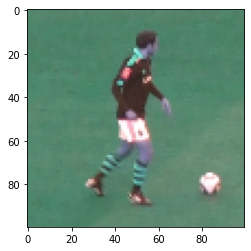

In [17]:
result = np.mean(y_prediction,axis=0)
fig = plt.imshow(X_test[35])
#plt.savefig('sample.png')

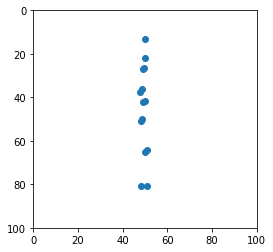

In [18]:
Y = result.reshape(300,14,2)
a = Y[35][:,0]
aa = list(reversed(a))
b = Y[35][:,1]
bb = list(reversed(b))
plt.figure(figsize=(4,4))
plt.xlim(0,100)
plt.ylim(100,0)
pic = plt.scatter(aa,bb)
plt.savefig('alexgelu.png')

In [13]:
loss_object =tf.keras.losses.MeanSquaredError()
def create_adversarial_pattern(input_image, input_label):
    with tf.GradientTape() as tape:
        tape.watch(input_image)
        prediction = model(input_image)
        loss = loss_object(input_label, prediction)
    gradient = tape.gradient(loss, input_image)
    signed_grad = tf.sign(gradient)
    return signed_grad

In [14]:
x = X-0.5
x_valid = X_valid-0.5
x_test = X_test-0.5

In [15]:
x_test = tf.convert_to_tensor(x_test, tf.float32, name='x_test')
yy_test = tf.convert_to_tensor(y_test, tf.float32, name='y_test')
perturbations = create_adversarial_pattern(x_test, yy_test)
perturbations[0].shape
perturbations[0]

<tf.Tensor: shape=(100, 100, 3), dtype=float32, numpy=
array([[[ 1.,  1., -1.],
        [-1., -1., -1.],
        [ 1., -1.,  1.],
        ...,
        [ 1., -1., -1.],
        [ 1.,  1.,  1.],
        [ 0.,  0.,  0.]],

       [[ 1.,  1., -1.],
        [ 1., -1.,  1.],
        [-1.,  1., -1.],
        ...,
        [-1., -1., -1.],
        [ 1.,  1., -1.],
        [ 0.,  0.,  0.]],

       [[-1., -1., -1.],
        [ 1.,  1., -1.],
        [-1.,  1., -1.],
        ...,
        [-1.,  1.,  1.],
        [ 1., -1., -1.],
        [ 0.,  0.,  0.]],

       ...,

       [[ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        ...,
        [-1., -1., -1.],
        [-1., -1., -1.],
        [ 0.,  0.,  0.]],

       [[ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        ...,
        [-1., -1.,  1.],
        [-1., -1., -1.],
        [ 0.,  0.,  0.]],

       [[ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        ...,
        [ 0.,  0., 

epsilons = 0:
the sum of euclidean_dis of all joint points: 0.0


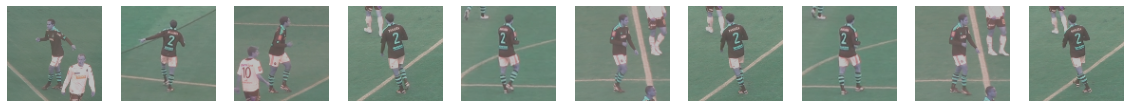

epsilons = 0.1:
the sum of euclidean_dis of all joint points: 153.8738867443842


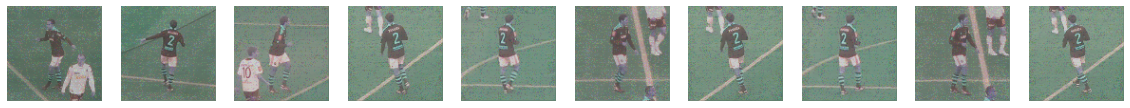

epsilons = 0.2:
the sum of euclidean_dis of all joint points: 213.92107334961162


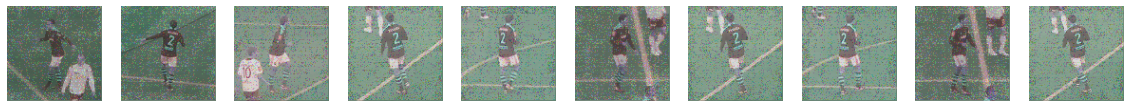

epsilons = 0.3:
the sum of euclidean_dis of all joint points: 226.3163668928079


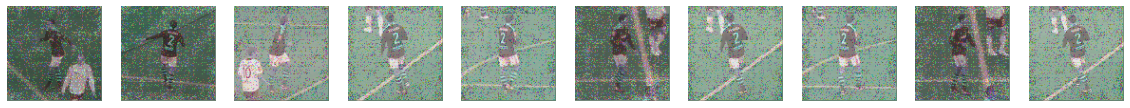

In [16]:
def display_images(image, label,adv_label,num=10):
    fig = plt.figure(figsize=(2*num,3)) 
    for i in range(num):   
        plt.subplot(1,num,i+1) 
        plt.imshow((image[i,:,:,:] + 1)/2) 
        plt.axis('off')
    plt.show()

epsilons = [0,0.10,0.20,0.30]
euclidean_dis_adv = []
for i, eps in enumerate(epsilons):
    print("epsilons = {}:".format(eps))
    test_x = tf.clip_by_value(x_test, -1, 1)
    predict_value = model.predict(test_x)
    adv_image = test_x + eps*perturbations
    adv_image = tf.clip_by_value(adv_image, -1, 1)
    adv_predict_value = model.predict(adv_image)
    
    
    diff = (predict_value-adv_predict_value)**2
    diff = diff.reshape((300,14,2))
    eu_dis = np.empty((300,14))
    for l in range(300):
        for k in range(14):
            eu_dis[l][k] = np.sqrt(sum(diff[l][k]))
    #eu_dis
    avg_eu_dis = []#each picture
    for j in range(eu_dis.shape[0]):
        avg_eu_dis.append(np.mean(eu_dis[j,:]))
    #print('avg eu dis in each picture:',avg_eu_dis,'\n','#test picture:',len(avg_eu_dis),'\n','overall_avg:',np.mean(avg_eu_dis))
    euclidean_dis_adv.append(np.mean(avg_eu_dis))
    print('the sum of euclidean_dis of all joint points:',euclidean_dis_adv[i])
    
    display_images(np.array(adv_image).reshape(300,100,100,3),predict_value,adv_predict_value)